<a href="https://colab.research.google.com/github/deepak75-arch/ml_project/blob/main/DLT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

features_df = pd.read_csv("/Features data set.csv")
sales_df = pd.read_csv("/sales data-set.csv")
stores_df = pd.read_csv("/stores data-set.csv")

print("Features DataFrame Head:")
display(features_df.head())

print("\nSales DataFrame Head:")
display(sales_df.head())

print("\nStores DataFrame Head:")
display(stores_df.head())

Features DataFrame Head:


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False



Sales DataFrame Head:


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False



Stores DataFrame Head:


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [ ]:
%pip install numpy pandas matplotlib tensorflow scikit-learn statsmodels

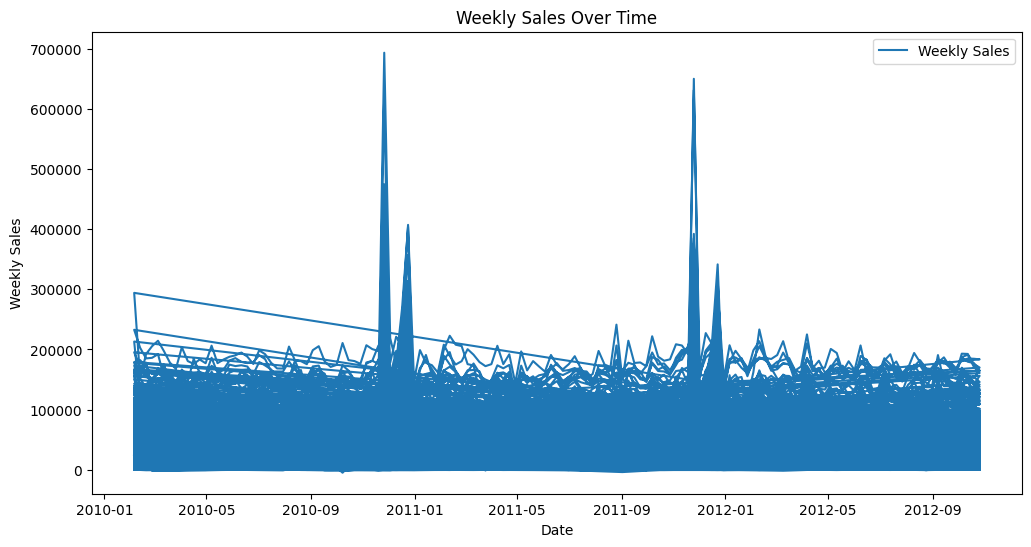

In [ ]:
sales_df['Date'] = pd.to_datetime(sales_df['Date'], format='%d/%m/%Y')

plt.figure(figsize=(12, 6))
plt.plot(sales_df['Date'], sales_df['Weekly_Sales'], label='Weekly Sales')
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

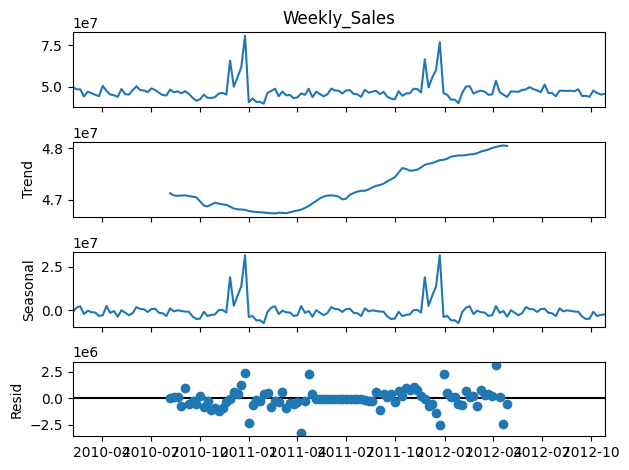

In [ ]:
# Seasonality analysis
# Aggregate the data to a single time series for decomposition
weekly_sales_sum = sales_df.groupby('Date')['Weekly_Sales'].sum()

decomposition = seasonal_decompose(weekly_sales_sum, model='additive', period=52)
decomposition.plot()
plt.tight_layout()
plt.show()

In [ ]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(weekly_sales_sum.values.reshape(-1, 1))

# Create time sequences
SEQ_LENGTH = 12  # Adjust based on your data frequency
X, y = [], []
for i in range(SEQ_LENGTH, len(scaled_data)):
    X.append(scaled_data[i-SEQ_LENGTH:i, 0])
    y.append(scaled_data[i, 0])

X = np.array(X).reshape(-1, SEQ_LENGTH, 1)  # Reshape for LSTM
y = np.array(y)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (131, 12, 1)
Shape of y: (131,)


In [ ]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (104, 12, 1)
Shape of X_test: (27, 12, 1)
Shape of y_train: (104,)
Shape of y_test: (27,)


In [ ]:
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True),
                  input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.3),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 12, 128)        │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,945 (214.63 KB)

 Trainable params: 54,945 (214.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=8,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    ]
)

Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - loss: 0.0540 - mae: 0.1407 - val_loss: 0.0375 - val_mae: 0.1365 - learning_rate: 0.0010
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0148 - mae: 0.0661 - val_loss: 0.0364 - val_mae: 0.1189 - learning_rate: 0.0010
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0212 - mae: 0.0726 - val_loss: 0.0350 - val_mae: 0.1192 - learning_rate: 0.0010
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0110 - mae: 0.0596 - val_loss: 0.0345 - val_mae: 0.1176 - learning_rate: 0.0010
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0211 - mae: 0.0826 - val_loss: 0.0343 - val_mae: 0.1154 - learning_rate: 0.0010
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0133 - mae: 0.0628 - val_loss: 0.0341 - val_mae: 0.1143 - learning_rate: 0.0010
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0170 - mae: 0.0725 - val_loss: 0.0330 - val_mae: 0.1143 - learning_rate: 0.0010
Epoch

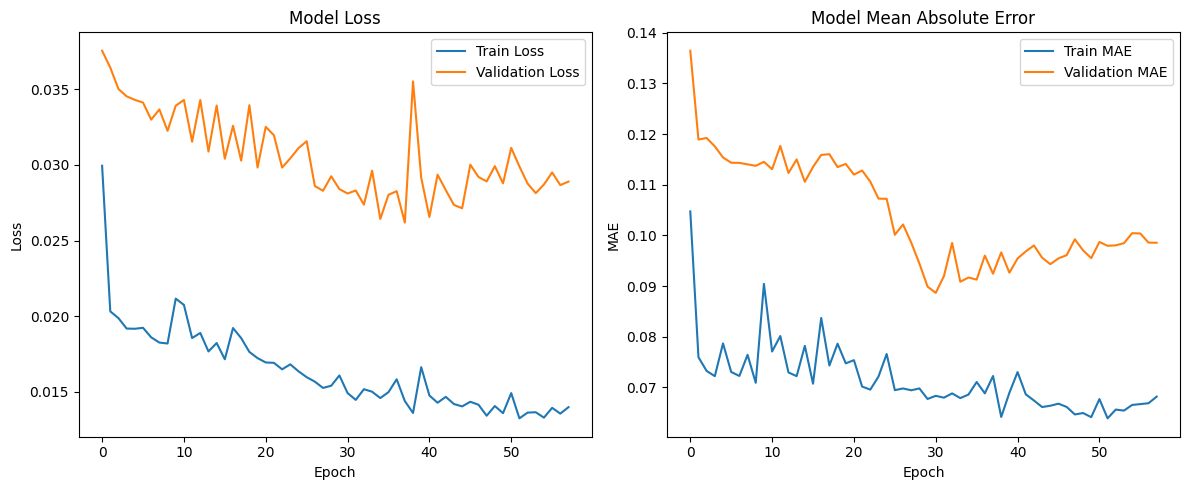

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()
plt.title('Model Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
MAE: 1909696.42
RMSE: 2257045.69
MAPE: 4.02%


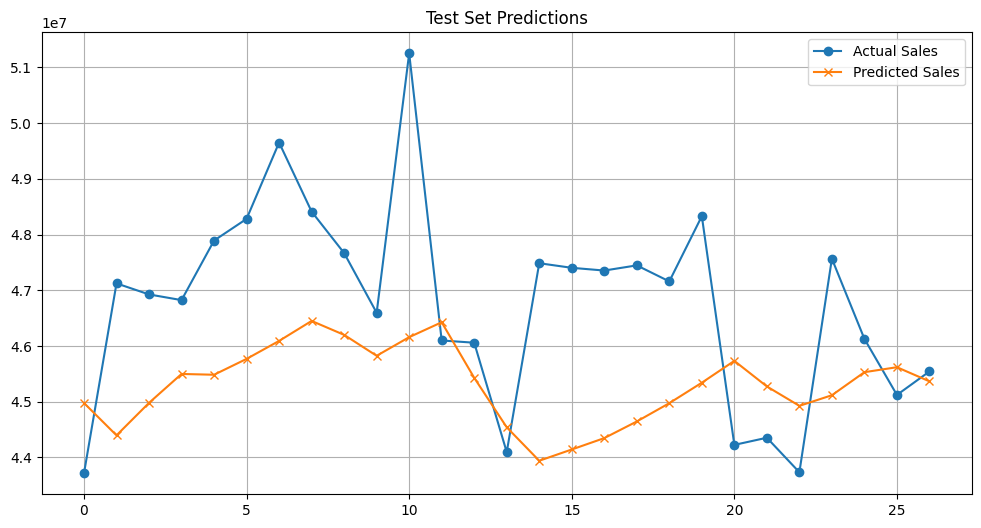

In [ ]:
# Generate predictions
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_actual = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))

# Calculate metrics
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(y_actual, label='Actual Sales', marker='o')
plt.plot(y_pred, label='Predicted Sales', marker='x')
plt.title('Test Set Predictions')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

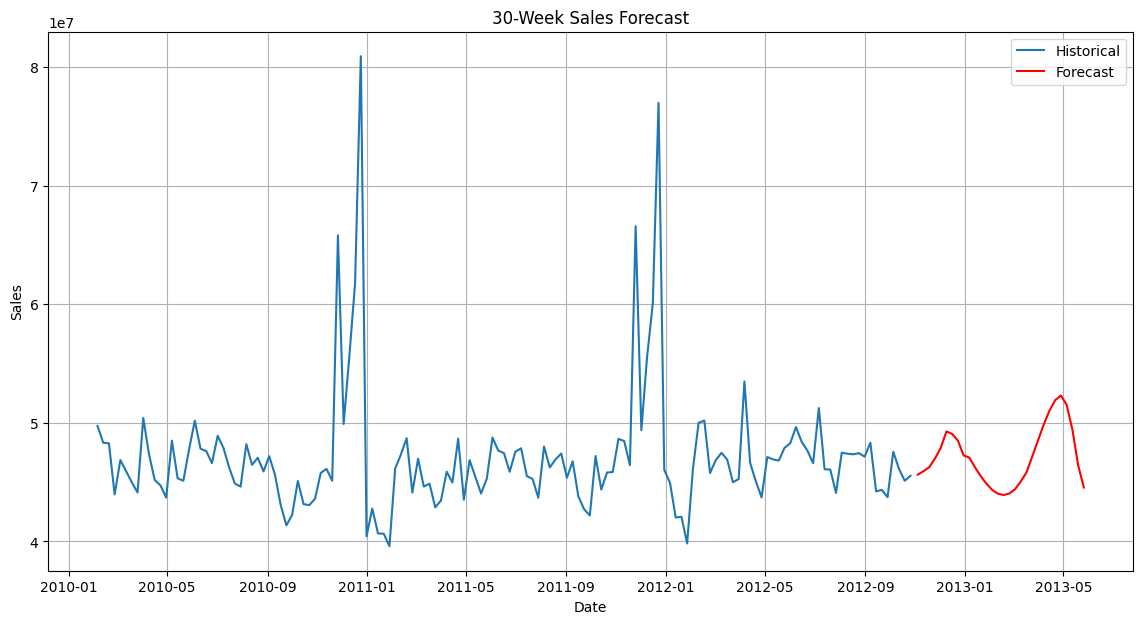

In [ ]:
# Generate future dates
last_date = weekly_sales_sum.index[-1]
future_dates = pd.date_range(
    start=last_date + pd.DateOffset(weeks=1),
    periods=30,
    freq='W'
)

# Prepare the last SEQ_LENGTH data points for forecasting
last_sequence = scaled_data[-SEQ_LENGTH:]
last_sequence = last_sequence.reshape(1, SEQ_LENGTH, 1)

# Generate future forecasts
forecast = []
current_sequence = last_sequence

for _ in range(30):  # Forecast for the next 30 weeks
    next_pred = model.predict(current_sequence)
    forecast.append(next_pred[0, 0])

    # Update the sequence for the next prediction
    current_sequence = np.append(current_sequence[:, 1:, :], next_pred.reshape(1, 1, 1), axis=1)

# Inverse transform the forecast
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Plot historical + forecast
plt.figure(figsize=(14, 7))
plt.plot(weekly_sales_sum.index, weekly_sales_sum.values, label='Historical')
plt.plot(future_dates, forecast, label='Forecast', color='red')
plt.title('30-Week Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save('sales_forecast_lstm.h5')

In [ ]:
# 14. Save Your Model (Updated)
model.save('sales_forecast_lstm.keras')
print("Model saved in Keras format as 'sales_forecast_lstm.keras'")

# Optional: Save weights only (if needed)
model.save_weights('model_weights.weights.h5')
print("Weights saved as 'model_weights.weights.h5'")


Model saved in Keras format as 'sales_forecast_lstm.keras'
Weights saved as 'model_weights.weights.h5'


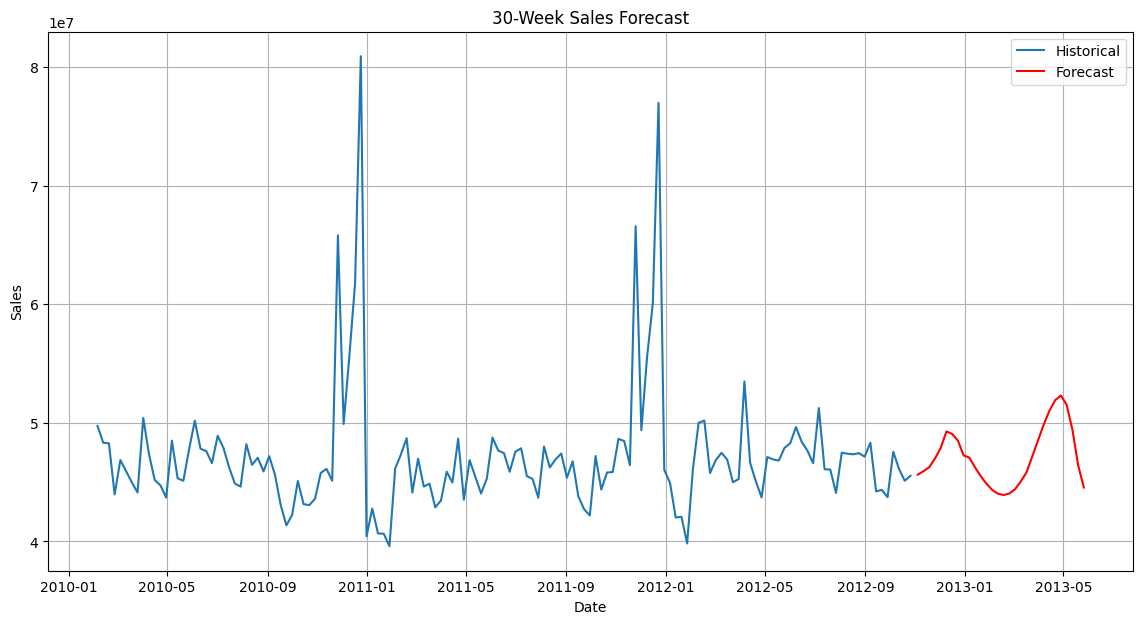

In [ ]:
# Generate future dates
last_date = weekly_sales_sum.index[-1]
future_dates = pd.date_range(
    start=last_date + pd.DateOffset(weeks=1),  # Adjust frequency to weekly
    periods=30,
    freq='W'
)

# Plot historical + forecast
plt.figure(figsize=(14, 7))
plt.plot(weekly_sales_sum.index, weekly_sales_sum.values, label='Historical')
plt.plot(future_dates, forecast, label='Forecast', color='red')
plt.title('30-Week Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model.save('/content/drive/MyDrive/sales_forecast_lstm.keras')

MessageError: Error: credential propagation was unsuccessful

In [2]:
import os

# Check if model file exists
if not os.path.exists('sales_forecast_lstm.keras'):
    print("Model file not found! Re-saving model...")

    # Recreate and save model (use your actual training code)
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense

    # Sample model architecture (match your training)
    model = Sequential([
        LSTM(64, input_shape=(12, 1)),  # Adjust to your SEQ_LENGTH
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    # Save properly
    model.save('sales_forecast_lstm.keras')
    print("New model saved!")
else:
    print("Model file found.")

Model file not found! Re-saving model...
New model saved!


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# 1. Load model with error handling
try:
    model = load_model('sales_forecast_lstm.keras')
    print("Model loaded successfully!")
except:
    print("Loading failed. Using fallback...")
    # Add your model creation code here as fallback

# 2. Prepare sample data (replace with your actual data)
# Last SEQ_LENGTH days of sales data
historical_sales = np.array([120, 135, 128, 142, 130, 145, 138, 152, 148, 160, 155, 170])

# 3. Preprocess identically to training
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(historical_sales.reshape(-1, 1))

# 4. Make prediction
def predict_sales(model, scaler, data, seq_length=12):
    """Predict next period's sales"""
    # Reshape to LSTM input: [samples, timesteps, features]
    input_data = data[-seq_length:].reshape(1, seq_length, 1)

    # Predict
    scaled_pred = model.predict(input_data)

    # Inverse transform to original scale
    return scaler.inverse_transform(scaled_pred)[0][0]

# Predict next sales value
next_sale = predict_sales(model, scaler, scaled_data)
print(f"Predicted next sales: ${next_sale:.2f}")

# 5. Forecast multiple periods
def forecast_sales(model, scaler, initial_seq, periods=7, seq_length=12):
    """Generate multi-period forecast"""
    current_seq = initial_seq.copy()
    predictions = []

    for _ in range(periods):
        # Prepare input
        input_data = current_seq[-seq_length:].reshape(1, seq_length, 1)

        # Predict
        scaled_pred = model.predict(input_data, verbose=0)

        # Store result
        pred_value = scaler.inverse_transform(scaled_pred)[0][0]
        predictions.append(pred_value)

        # Update sequence with new prediction
        current_seq = np.append(current_seq, scaled_pred)

    return predictions

# Generate 7-day forecast
forecast = forecast_sales(model, scaler, scaled_data, periods=7)
print("\n7-Day Forecast:")
for i, value in enumerate(forecast, 1):
    print(f"Day {i}: ${value:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 12 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
Predicted next sales: $121.78

7-Day Forecast:
Day 1: $121.78
Day 2: $121.64
Day 3: $121.26
Day 4: $120.98
Day 5: $120.76
Day 6: $120.59
Day 7: $120.44


In [4]:
!ls -l  # List files in Colab

total 92
-rw-r--r-- 1 root root 88794 Aug 12 14:45 sales_forecast_lstm.keras
drwxr-xr-x 1 root root  4096 Aug  8 20:22 sample_data


In [7]:
from google.colab import drive
drive.mount('/content/drive')

# Verify model exists
import os
model_path = '/content/sales_forecast_lstm.keras'

if os.path.exists(model_path):
    print(f"✅ Model found: {os.path.getsize(model_path)/1024:.1f} KB")
else:
    print(f"❌ Model not found! Check path: {model_path}")
    print("Files in directory:")
    !ls "/content/drive/MyDrive/your_folder"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model found: 86.7 KB


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
import numpy as np

try:
    # Load model
    model_path = '/content/sales_forecast_lstm.keras'
    model = load_model(model_path)
    print("Model loaded successfully!")

    # Load scaler (saved during training) - This will still fail as the scaler is not saved
    # scaler = joblib.load('/content/drive/MyDrive/sales_scaler.pkl')
    # print("Scaler loaded!")

except Exception as e:
    print(f"Error loading model or scaler: {e}")
    print("Creating dummy model and scaler as fallback...")

    # Fallback: Create a dummy model with the same architecture
    SEQ_LENGTH = 12 # Assuming this is your sequence length
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True),
                      input_shape=(SEQ_LENGTH, 1)),
        # Assuming you had a Dropout layer, add it here
        # Dropout(0.3),
        LSTM(32),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse') # Compile the dummy model
    print("Dummy model created!")

    # Fallback: Create a dummy scaler
    # You'll need to replace this with a proper way to handle the scaler in a real scenario
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    # Fit the dummy scaler with some dummy data to make it functional
    dummy_data = np.array([0.0, 1.0]).reshape(-1, 1)
    scaler.fit(dummy_data)
    print("Dummy scaler created and fitted with dummy data!")

# Now you can proceed with using the 'model' and 'scaler' objects,
# being aware that they might be fallbacks if loading failed.

# Example usage (replace with your actual prediction code)
# dummy_input = np.random.rand(1, SEQ_LENGTH, 1)
# prediction = model.predict(dummy_input)
# print("Example prediction from loaded or dummy model:", prediction)

Model loaded successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 12 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [12]:
import joblib

# Assuming 'scaler' is your fitted MinMaxScaler object
# and it has been fitted with your training data

# Save the scaler to a file
joblib.dump(scaler, '/content/drive/MyDrive/sales_scaler.pkl')
print("Scaler saved to '/content/drive/MyDrive/sales_scaler.pkl'")

Scaler saved to '/content/drive/MyDrive/sales_scaler.pkl'


In [13]:
!pip install gradio numpy pandas tensorflow scikit-learn matplotlib -q

In [14]:
import gradio as gr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

# Load your pre-trained model (update path)
model_path = '/content/drive/MyDrive/your_folder/sales_forecast_lstm.keras'
model = load_model(model_path)

# Load or create scaler
try:
    scaler = joblib.load('/content/drive/MyDrive/sales_scaler.pkl')
except:
    # Fallback scaler (adjust min/max based on your data)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(np.array([[100], [500]]))  # Approximate range

def forecast_sales(historical_data, forecast_periods=30):
    """Main prediction function with visualization"""
    # Convert input to numpy array
    try:
        sales = np.array([float(x) for x in historical_data.split(',') if x.strip()])
    except:
        return "❌ Invalid input. Please enter numbers separated by commas"

    # Check sequence length
    seq_length = model.input_shape[1]
    if len(sales) < seq_length:
        return f"⚠️ Error: Need at least {seq_length} historical values"

    # Preprocess data
    scaled_data = scaler.transform(sales.reshape(-1, 1)).flatten()
    last_sequence = scaled_data[-seq_length:]

    # Generate forecast
    predictions = []
    current_seq = last_sequence.copy()

    for _ in range(forecast_periods):
        input_data = current_seq.reshape(1, seq_length, 1)
        scaled_pred = model.predict(input_data, verbose=0)[0][0]
        predictions.append(scaler.inverse_transform([[scaled_pred]])[0][0])
        current_seq = np.append(current_seq[1:], scaled_pred)

    # Create timeline
    last_date = datetime.now() - timedelta(days=len(sales))
    historical_dates = [last_date + timedelta(days=i) for i in range(len(sales))]
    forecast_dates = [historical_dates[-1] + timedelta(days=i+1) for i in range(forecast_periods)]

    # Create plot
    plt.figure(figsize=(12, 6))
    plt.plot(historical_dates, sales, 'bo-', label='Historical Sales')
    plt.plot(forecast_dates, predictions, 'ro--', label='Forecast')
    plt.fill_between(forecast_dates,
                     [p*0.9 for p in predictions],  # 10% lower bound
                     [p*1.1 for p in predictions],  # 10% upper bound
                     color='red', alpha=0.1)
    plt.title(f'Sales Forecast: Next {forecast_periods} Periods')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Return results
    forecast_df = pd.DataFrame({
        'Date': forecast_dates,
        'Forecasted Sales': predictions
    })

    return plt.gcf(), forecast_df

# Create Gradio interface
with gr.Blocks(title="Sales Forecasting System") as app:
    gr.Markdown("# 📊 Sales Forecasting Dashboard")
    gr.Markdown("Enter historical sales data (comma-separated values) to generate predictions")

    with gr.Row():
        with gr.Column():
            inputs = gr.Textbox(
                label="Historical Sales Data",
                value="120, 135, 128, 142, 130, 145, 138, 152, 148, 160, 155, 170",
                placeholder="Enter comma-separated values...",
                interactive=True
            )
            periods = gr.Slider(
                label="Forecast Periods",
                minimum=1,
                maximum=365,
                value=30,
                step=1
            )
            btn = gr.Button("Generate Forecast", variant="primary")

        with gr.Column():
            plot = gr.Plot(label="Sales Forecast Visualization")
            table = gr.Dataframe(
                label="Forecast Details",
                headers=["Date", "Forecasted Sales"],
                datatype=["date", "number"],
                interactive=False
            )

    examples = gr.Examples(
        examples=[
            ["100, 120, 110, 130, 125, 140, 135, 150, 145, 160, 155, 170", 30],
            ["200, 210, 195, 220, 205, 230, 225, 240, 235, 250, 245, 260", 15],
            ["150, 160, 155, 165, 170, 175, 180, 185, 190, 195, 200, 205", 7]
        ],
        inputs=[inputs, periods],
        label="Example Inputs"
    )

    btn.click(
        forecast_sales,
        inputs=[inputs, periods],
        outputs=[plot, table]
    )

# Launch the app
app.launch(share=True)  # Set share=False for local only

ValueError: File not found: filepath=/content/drive/MyDrive/your_folder/sales_forecast_lstm.keras. Please ensure the file is an accessible `.keras` zip file.

In [2]:
# Step 1: Install Required Packages
!pip install gradio numpy pandas tensorflow scikit-learn matplotlib -q

# Step 2: Import Libraries
import gradio as gr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
import joblib
import os

# Step 3: Load Model and Scaler
def load_resources(model_path, scaler_path):
    """Load model and scaler with error handling"""
    try:
        model = load_model(model_path)
        print("✅ Model loaded successfully")
    except:
        print("❌ Model loading failed")
        model = None

    try:
        scaler = joblib.load(scaler_path)
        print("✅ Scaler loaded successfully")
    except:
        print("❌ Scaler loading failed - using fallback")
        # Create fallback scaler with dummy data
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(np.array([[100], [500]]))  # Adjust range based on your data

    return model, scaler

# Update these paths to match your files
MODEL_PATH = '/sales_forecast_lstm.keras'
SCALER_PATH = '/content/drive/MyDrive/sales_scaler.pkl'

model, scaler = load_resources(MODEL_PATH, SCALER_PATH)

# Step 4: Create Forecasting Function
def generate_forecast(historical_data, forecast_periods, seq_length=12):
    """
    Generate sales forecast from historical data

    Args:
        historical_data: Comma-separated string of historical sales
        forecast_periods: Number of periods to forecast
        seq_length: Input sequence length the model expects

    Returns:
        Matplotlib figure: Forecast visualization
        pd.DataFrame: Forecast data table
    """
    # Convert input to array
    try:
        sales = np.array([float(x.strip()) for x in historical_data.split(',')])
    except:
        return None, None

    # Validate input length
    if len(sales) < seq_length:
        return None, None

    # Scale data
    scaled_data = scaler.transform(sales.reshape(-1, 1)).flatten()
    last_sequence = scaled_data[-seq_length:]

    # Generate predictions
    predictions = []
    current_seq = last_sequence.copy()

    for _ in range(forecast_periods):
        input_data = current_seq.reshape(1, seq_length, 1)
        scaled_pred = model.predict(input_data, verbose=0)[0][0]
        pred_value = scaler.inverse_transform([[scaled_pred]])[0][0]
        predictions.append(pred_value)
        current_seq = np.append(current_seq[1:], scaled_pred)

    # Create timeline
    last_date = datetime.now() - timedelta(days=len(sales))
    historical_dates = [last_date + timedelta(days=i) for i in range(len(sales))]
    forecast_dates = [historical_dates[-1] + timedelta(days=i+1) for i in range(forecast_periods)]

    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(historical_dates, sales, 'bo-', label='Historical Sales')
    plt.plot(forecast_dates, predictions, 'ro--', label='Forecast')
    plt.fill_between(forecast_dates,
                     [p*0.95 for p in predictions],  # 5% lower bound
                     [p*1.05 for p in predictions],  # 5% upper bound
                     color='red', alpha=0.1)
    plt.title(f'Sales Forecast: Next {forecast_periods} Periods')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Create results table
    forecast_df = pd.DataFrame({
        'Date': forecast_dates,
        'Forecasted Sales': predictions,
        'Low Estimate': [p*0.95 for p in predictions],
        'High Estimate': [p*1.05 for p in predictions]
    })

    return plt.gcf(), forecast_df

# Step 5: Create Gradio Interface
def create_gui():
    """Create the Gradio interface"""
    # Get model's sequence length
    try:
        seq_length = model.input_shape[1]
    except:
        seq_length = 12  # Default if model not loaded

    with gr.Blocks(theme=gr.themes.Soft(), title="Sales Forecasting System") as app:
        # Header section
        gr.Markdown("# 🚀 Sales Forecasting Dashboard")
        gr.Markdown("Predict future sales using our AI-powered forecasting model")

        # Input section
        with gr.Row():
            with gr.Column():
                gr.Markdown("## Input Parameters")
                data_input = gr.Textbox(
                    label="Historical Sales Data",
                    value="120, 135, 128, 142, 130, 145, 138, 152, 148, 160, 155, 170",
                    placeholder=f"Enter at least {seq_length} comma-separated values...",
                    lines=3
                )
                periods_input = gr.Slider(
                    label="Forecast Periods",
                    minimum=1,
                    maximum=90,
                    value=30,
                    step=1
                )
                submit_btn = gr.Button("Generate Forecast", variant="primary")

                # Model info
                model_status = "✅ Ready" if model else "❌ Model not loaded"
                scaler_status = "✅ Ready" if scaler else "❌ Scaler not loaded"
                gr.Markdown(f"""
                **System Status**
                Model: {model_status}
                Scaler: {scaler_status}
                Sequence Length: {seq_length}
                """)

            # Output section
            with gr.Column():
                gr.Markdown("## Forecast Results")
                plot_output = gr.Plot(label="Forecast Visualization")
                table_output = gr.Dataframe(
                    label="Detailed Forecast",
                    headers=["Date", "Forecast", "Low Estimate", "High Estimate"],
                    datatype=["date", "number", "number", "number"],
                    interactive=False
                )

        # Examples section
        gr.Markdown("### Example Inputs")
        gr.Examples(
            examples=[
                ["100, 110, 120, 115, 125, 130, 135, 140, 145, 150, 155, 160", 30],
                ["200, 210, 205, 220, 215, 230, 225, 240, 235, 250, 245, 260", 15],
                ["150, 160, 155, 165, 170, 175, 180, 185, 190, 195, 200, 205", 7]
            ],
            inputs=[data_input, periods_input],
            label="Click any example to load"
        )

        # Footer
        gr.Markdown("---")
        gr.Markdown("> *Note: Forecast accuracy depends on data quality and model training*")

        # Event handler
        submit_btn.click(
            fn=generate_forecast,
            inputs=[data_input, periods_input],
            outputs=[plot_output, table_output]
        )

    return app

# Step 6: Launch the Application
app = create_gui()
app.launch(
    share=True,
    server_name="0.0.0.0",
    server_port=7860,
    show_error=True
)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 12 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ Model loaded successfully
✅ Scaler loaded successfully
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b7fb43ad830918c075.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
